[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pySTEPS/pysteps/blob/master/examples/my_first_nowcast.ipynb)

# My first precipitation nowcast

In this example, we will use pysteps to compute and plot an extrapolation nowcast using the NSSL's Multi-Radar/Multi-Sensor System
([MRMS](https://www.nssl.noaa.gov/projects/mrms/)) rain rate product.

The MRMS precipitation product is available every 2 minutes, over the contiguous US.
Each precipitation composite has 3500 x 7000 grid points, separated 1 km from each other.

## Set-up Colab environment

**Important**: In colab, execute this section one cell at a time. Trying to excecute all the cells at once may results in cells being skipped and some dependencies not being installed.

First, let's set up our working environment. Note that these steps are only needed to work with google colab.

To install pysteps locally, you can follow [these instructions](https://pysteps.readthedocs.io/en/latest/user_guide/install_pysteps.html).

First, let's install the latest Pysteps version from the Python Package Index (PyPI) using pip. This will also install the minimal dependencies needed to run pysteps.

#### Install optional dependencies

Now, let's install the optional dependendies that will allow us to plot and read the example data.
- pygrib: to read the MRMS data grib format
- pyproj: needed by pygrib

**NOTE:** Do not import pysteps in this notebook until the following optional dependencies are loaded. Otherwise, pysteps will assume that they are not installed and some of its functionalities won't work.

#### Install pysteps

Now that all dependencies are installed, we can install pysteps.

## Getting the example data

Now that we have the environment ready, let's install the example data and configure the pysteps's default parameters by following [this tutorial](https://pysteps.readthedocs.io/en/latest/user_guide/example_data.html).

First, we will use the [pysteps.datasets.download_pysteps_data()](https://pysteps.readthedocs.io/en/latest/generated/pysteps.datasets.download_pysteps_data.html) function to download the data.


In [49]:
# Import the helper functions
from pysteps.datasets import download_pysteps_data, create_default_pystepsrc
from datetime import datetime
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np

from pysteps import io, motion, rcparams
from pysteps.utils import conversion, transformation
from pysteps.visualization import plot_precip_field, quiver

# # Download the pysteps data in the "pysteps_data"
# download_pysteps_data("pysteps_data")

Next, we need to create a default configuration file that points to the downloaded data.
By default, pysteps will place the configuration file in `$HOME/.pysteps` (unix and Mac OS X) or `$USERPROFILE/pysteps` (windows).
To quickly create a configuration file, we will use the [pysteps.datasets.create_default_pystepsrc()](https://pysteps.readthedocs.io/en/latest/generated/pysteps.datasets.create_default_pystepsrc.html#pysteps.datasets.create_default_pystepsrc) helper function.

In [51]:
# If the configuration file is placed in one of the default locations
# (https://pysteps.readthedocs.io/en/latest/user_guide/set_pystepsrc.html#configuration-file-lookup)
# it will be loaded automatically when pysteps is imported.
config_file_path = create_default_pystepsrc("pysteps_data")

date = datetime.strptime("201505151630", "%Y%m%d%H%M")
data_source = rcparams.data_sources["mch"]

Since pysteps was already initialized in this notebook, we need to load the new configuration file and update the default configuration.

In [32]:
# Import pysteps and load the new configuration file
import pysteps

_ = pysteps.load_config_file(config_file_path, verbose=True)

Pysteps configuration file found at: /Users/phucdang/.pysteps/pystepsrc



Let's see what the default parameters look like (these are stored in the
[pystepsrc file](https://pysteps.readthedocs.io/en/latest/user_guide/set_pystepsrc.html)). We will be using them to load the MRMS data set.

In [33]:
# The default parameters are stored in pysteps.rcparams.
from pprint import pprint

# pprint(pysteps.rcparams.data_sources["nhb"])

This should have printed the following lines:

- `fn_ext`: 'grib2' -- The file extension
- `fn_pattern`: 'PrecipRate_00.00_%Y%m%d-%H%M%S' -- The file naming convention of the MRMS data.
- `importer`: 'mrms_grib' -- The name of the importer for the MRMS data.
- `importer_kwargs`: {} -- Extra options provided to the importer. None in this example.
- `path_fmt`: '%Y/%m/%d' -- The folder structure in which the files are stored. Here, year/month/day/filename.
- `root_path`: '/content/pysteps_data/mrms' -- The root path of the MRMS-data.
- `timestep`: 2 -- The temporal interval of the (radar) rainfall data

Note that the default `timestep` parameter is 2 minutes, which corresponds to the time interval at which the MRMS product is available.

## Load the MRMS example data

Now that we have installed the example data, let's import the example MRMS dataset using the [load_dataset()](https://pysteps.readthedocs.io/en/latest/generated/pysteps.datasets.load_dataset.html) helper function from the `pysteps.datasets` module.

We import 1 hour and 10 minutes of data, which corresponds to a sequence of 35 frames of 2-D precipitation composites.
Note that importing the data takes approximately 30 seconds.

In [34]:
from pysteps.datasets import load_dataset

# We'll import the time module to measure the time the importer needed
import time

start_time = time.time()

# Import the data
precipitation, metadata, timestep = load_dataset(
    "mch", frames=20
)  # precipitation in mm/h

end_time = time.time()

print("Precipitation data imported")
print("Importing the data took ", (end_time - start_time), " seconds")

Precipitation data imported
Importing the data took  0.1424570083618164  seconds


In [35]:
metadata

{'projection': '+proj=somerc  +lon_0=7.43958333333333 +lat_0=46.9524055555556 +k_0=1 +x_0=600000 +y_0=200000 +ellps=bessel +towgs84=674.374,15.056,405.346,0,0,0,0 +units=m +no_defs',
 'x1': 255000.0,
 'y1': -160000.0,
 'x2': 965000.0,
 'y2': 480000.0,
 'xpixelsize': 1000.0,
 'ypixelsize': 1000.0,
 'cartesian_unit': 'm',
 'yorigin': 'upper',
 'accutime': 5,
 'unit': 'mm/h',
 'transform': None,
 'zerovalue': 0.0,
 'threshold': 0.009909609120596347,
 'institution': 'MeteoSwiss',
 'product': 'AQC',
 'zr_a': 316.0,
 'zr_b': 1.5,
 'timestamps': array([datetime.datetime(2015, 5, 15, 15, 45),
        datetime.datetime(2015, 5, 15, 15, 50),
        datetime.datetime(2015, 5, 15, 15, 55),
        datetime.datetime(2015, 5, 15, 16, 0),
        datetime.datetime(2015, 5, 15, 16, 5),
        datetime.datetime(2015, 5, 15, 16, 10),
        datetime.datetime(2015, 5, 15, 16, 15),
        datetime.datetime(2015, 5, 15, 16, 20),
        datetime.datetime(2015, 5, 15, 16, 25),
        datetime.datetime(

In [36]:
precipitation

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

Let's have a look at the values returned by the `load_dataset()` function.

- `precipitation`: A numpy array with (time, latitude, longitude) dimensions.
- `metadata`: A dictionary with additional information (pixel sizes, map projections, etc.).
- `timestep`: Time separation between each sample (in minutes)

In [37]:
# Let's inspect the shape of the imported data array
precipitation.shape

(20, 640, 710)

Note that the shape of the precipitation is 4 times smaller than the raw MRMS data (3500 x 7000).
The `load_dataset()` function uses the default parameters from `importers` to read the data. By default, the MRMS importer upscales the data 4x. That is, from ~1km resolution to ~4km. It also uses single precision to reduce the memory requirements.
Thanks to the upscaling, the memory footprint of this example dataset is ~200Mb instead of the 3.1Gb of the raw (3500 x 7000) data.

In [38]:
timestep  # In minutes

5

In [39]:
pprint(metadata)

{'accutime': 5,
 'cartesian_unit': 'm',
 'institution': 'MeteoSwiss',
 'product': 'AQC',
 'projection': '+proj=somerc  +lon_0=7.43958333333333 +lat_0=46.9524055555556 '
               '+k_0=1 +x_0=600000 +y_0=200000 +ellps=bessel '
               '+towgs84=674.374,15.056,405.346,0,0,0,0 +units=m +no_defs',
 'threshold': 0.009909609120596347,
 'timestamps': array([datetime.datetime(2015, 5, 15, 15, 45),
       datetime.datetime(2015, 5, 15, 15, 50),
       datetime.datetime(2015, 5, 15, 15, 55),
       datetime.datetime(2015, 5, 15, 16, 0),
       datetime.datetime(2015, 5, 15, 16, 5),
       datetime.datetime(2015, 5, 15, 16, 10),
       datetime.datetime(2015, 5, 15, 16, 15),
       datetime.datetime(2015, 5, 15, 16, 20),
       datetime.datetime(2015, 5, 15, 16, 25),
       datetime.datetime(2015, 5, 15, 16, 30),
       datetime.datetime(2015, 5, 15, 16, 35),
       datetime.datetime(2015, 5, 15, 16, 40),
       datetime.datetime(2015, 5, 15, 16, 45),
       datetime.datetime(2015, 5

# Time to make a nowcast

So far, we have 1 hour and 10 minutes of precipitation images, separated 2 minutes from each other.
But, how do we use that data to run a precipitation forecast?

A simple way is by extrapolating the precipitation field, assuming it will continue to move as observed in the recent past, and without changes in intensity. This is commonly known as *Lagrangian persistence*.

The first step to run our nowcast based on Lagrangian persistence, is the estimation of the motion field from a sequence of past precipitation observations.
We use the Lucas-Kanade (LK) optical flow method implemented in pysteps.
This method follows a local tracking approach that relies on the OpenCV package.
Local features are tracked in a sequence of two or more radar images.
The scheme includes a final interpolation step to produce a smooth field of motion vectors.
Other optical flow methods are also available in pysteps.
Check the full list [here](https://pysteps.readthedocs.io/en/latest/pysteps_reference/motion.html).

Now let's use the first 5 precipitation images (10 min) to estimate the motion field of the radar pattern and the remaining 30 images (1h) to evaluate the quality of our forecast.

In [40]:
# precipitation[0:5] -> Used to find motion (past data). Let's call it training precip.
train_precip = precipitation[0:5]

# precipitation[5:] -> Used to evaluate forecasts (future data, not available in "real" forecast situation)
# Let's call it observed precipitation because we will use it to compare our forecast with the actual observations.
observed_precip = precipitation[3:]

Let's see what this 'training' precipitation event looks like using the [pysteps.visualization.plot_precip_field](https://pysteps.readthedocs.io/en/latest/generated/pysteps.visualization.precipfields.plot_precip_field.html) function.

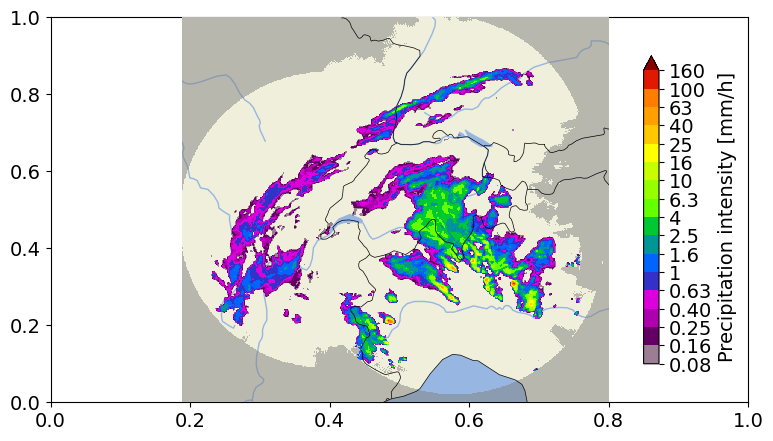

In [41]:
from matplotlib import pyplot as plt
from pysteps.visualization import plot_precip_field

# Set a figure size that looks nice ;)
plt.figure(figsize=(9, 5), dpi=100)

# Plot the last rainfall field in the "training" data.
# train_precip[-1] -> Last available composite for nowcasting.
plot_precip_field(train_precip[-1], geodata=metadata, axis="off")
plt.show()  # (This line is actually not needed if you are using jupyter notebooks)

Did you note the **shaded grey** regions? Those are the regions were no valid observations where available to estimate the precipitation (e.g., due to ground clutter, no radar coverage, or radar beam blockage).
Those regions need to be handled with care when we run our nowcast.

### Data exploration

Before we produce a forecast, let's explore the precipitation data. In particular, let's see how the distribution of the rain rate values looks.

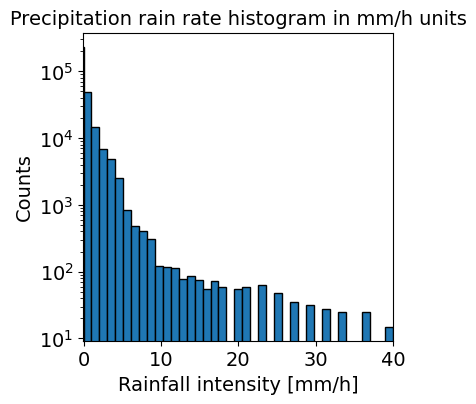

In [42]:
import numpy as np

# Let's define some plotting default parameters for the next plots
# Note: This is not strictly needed.
plt.rc("figure", figsize=(4, 4))
plt.rc("figure", dpi=100)
plt.rc("font", size=14)  # controls default text sizes
plt.rc("axes", titlesize=14)  # fontsize of the axes title
plt.rc("axes", labelsize=14)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=14)  # fontsize of the tick labels
plt.rc("ytick", labelsize=14)  # fontsize of the tick labels

# Let's use the last available composite for nowcasting from the "training" data (train_precip[-1])
# Also, we will discard any invalid value.
valid_precip_values = train_precip[-1][~np.isnan(train_precip[-1])]

# Plot the histogram
bins = np.concatenate(([-0.01, 0.01], np.linspace(1, 40, 39)))
plt.hist(valid_precip_values, bins=bins, log=True, edgecolor="black")
plt.autoscale(tight=True, axis="x")
plt.xlabel("Rainfall intensity [mm/h]")
plt.ylabel("Counts")
plt.title("Precipitation rain rate histogram in mm/h units")
plt.show()

The histogram shows that rain rate values have a non-Gaussian and asymmetric distribution that is bounded at zero. Also, the probability of occurrence decays extremely fast with increasing rain rate values (note the logarithmic y-axis).


For better performance of the motion estimation algorithms, we can convert the rain rate values (in mm/h) to a more log-normal distribution  of rain rates by applying the following logarithmic transformation:

\begin{equation}
R\rightarrow
\begin{cases}
    10\log_{10}R, & \text{if } R\geq 0.1\text{mm h$^{-1}$} \\
    -15,          & \text{otherwise}
\end{cases}
\end{equation}

The transformed precipitation corresponds to logarithmic rain rates in units of dBR. The value of −15 dBR is equivalent to assigning a rain rate of approximately 0.03 mm h$^{−1}$ to the zeros.

In [43]:
from pysteps.utils import transformation

# Log-transform the data to dBR.
# The threshold of 0.1 mm/h sets the fill value to -15 dBR.
train_precip_dbr, metadata_dbr = transformation.dB_transform(
    train_precip, metadata, threshold=0.1, zerovalue=-15.0
)

Let's inspect the resulting **transformed precipitation** distribution.

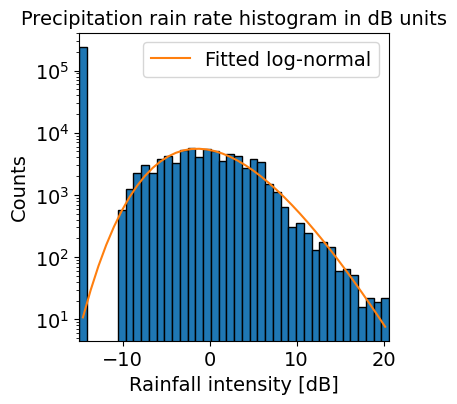

In [44]:
# Only use the valid data!
valid_precip_dbr = train_precip_dbr[-1][~np.isnan(train_precip_dbr[-1])]

plt.figure(figsize=(4, 4), dpi=100)

# Plot the histogram
counts, bins, _ = plt.hist(valid_precip_dbr, bins=40, log=True, edgecolor="black")
plt.autoscale(tight=True, axis="x")
plt.xlabel("Rainfall intensity [dB]")
plt.ylabel("Counts")
plt.title("Precipitation rain rate histogram in dB units")

# Let's add a lognormal distribution that fits that data to the plot.
import scipy

bin_center = (bins[1:] + bins[:-1]) * 0.5
bin_width = np.diff(bins)

# We will only use one composite to fit the function to speed up things.
# First, remove the no precip areas."
precip_to_fit = valid_precip_dbr[valid_precip_dbr > -15]

fit_params = scipy.stats.lognorm.fit(precip_to_fit)

fitted_pdf = scipy.stats.lognorm.pdf(bin_center, *fit_params)

# Multiply pdf by the bin width and the total number of grid points: pdf -> total counts per bin.
fitted_pdf = fitted_pdf * bin_width * precip_to_fit.size

# Plot the log-normal fit
plt.plot(bin_center, fitted_pdf, label="Fitted log-normal")
plt.legend()
plt.show()

That looks more like a log-normal distribution. Note the large peak at -15dB. That peak corresponds to "zero" (below threshold) precipitation. The jump with no data in between -15 and -10 dB is caused by the precision of the data, which we had set to 1 decimal. Hence, the lowest precipitation intensities (above zero) are 0.1 mm/h (= -10 dB).

## Compute the nowcast

These are the minimal steps to compute a short-term forecast using Lagrangian extrapolation of the precipitation patterns:

 1. Estimate the precipitation motion field.
 1. Use the motion field to advect the most recent radar rainfall field and produce an extrapolation forecast.

### Estimate the motion field

Now we can estimate the motion field. Here we use a local feature-tracking approach (Lucas-Kanade).
However, check the other methods available in the [pysteps.motion](https://pysteps.readthedocs.io/en/latest/pysteps_reference/motion.html) module.

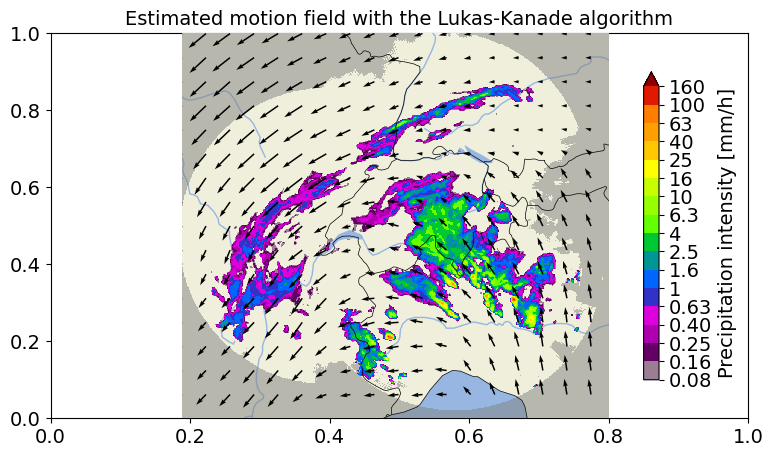

In [45]:
# Estimate the motion field with Lucas-Kanade
from pysteps import motion
from pysteps.visualization import plot_precip_field, quiver

# Import the Lucas-Kanade optical flow algorithm
oflow_method = motion.get_method("LK")

# Estimate the motion field from the training data (in dBR)
motion_field = oflow_method(train_precip_dbr)

## Plot the motion field.
# Use a figure size that looks nice ;)
plt.figure(figsize=(9, 5), dpi=100)
plt.title("Estimated motion field with the Lukas-Kanade algorithm")

# Plot the last rainfall field in the "training" data.
# Remember to use the mm/h precipitation data since plot_precip_field assumes
# mm/h by default. You can change this behavior using the "units" keyword.
plot_precip_field(train_precip[-1], geodata=metadata, axis="off")

# Plot the motion field vectors
quiver(motion_field, geodata=metadata, step=40)

plt.show()

### Extrapolate the observations

We have all ingredients to make an extrapolation nowcast now.
The final step is to advect the most recent radar rainfall field along the estimated motion field, producing an extrapolation forecast.

In [46]:
from pysteps import nowcasts

start = time.time()

# Extrapolate the last radar observation
extrapolate = nowcasts.get_method("extrapolation")

# You can use the precipitation observations directly in mm/h for this step.
last_observation = train_precip[-1]

last_observation[~np.isfinite(last_observation)] = metadata["zerovalue"]

# We set the number of leadtimes (the length of the forecast horizon) to the
# length of the observed/verification preipitation data. In this way, we'll get
# a forecast that covers these time intervals.
n_leadtimes = observed_precip.shape[0]

# Advect the most recent radar rainfall field and make the nowcast.
precip_forecast = extrapolate(train_precip[-1], motion_field, n_leadtimes)

# This shows the shape of the resulting array with [time intervals, rows, cols]
print("The shape of the resulting array is: ", precip_forecast.shape)

end = time.time()
print("Advecting the radar rainfall fields took ", (end - start), " seconds")

The shape of the resulting array is:  (17, 640, 710)
Advecting the radar rainfall fields took  2.1930911540985107  seconds


Let's inspect the last forecast time (hence this is the forecast rainfall an hour ahead).

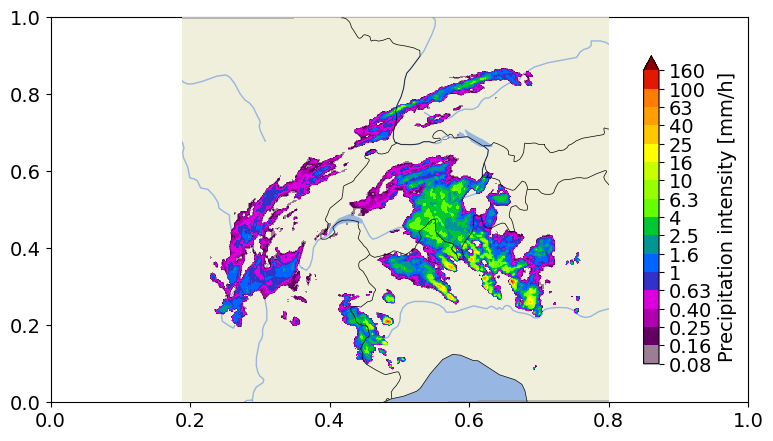

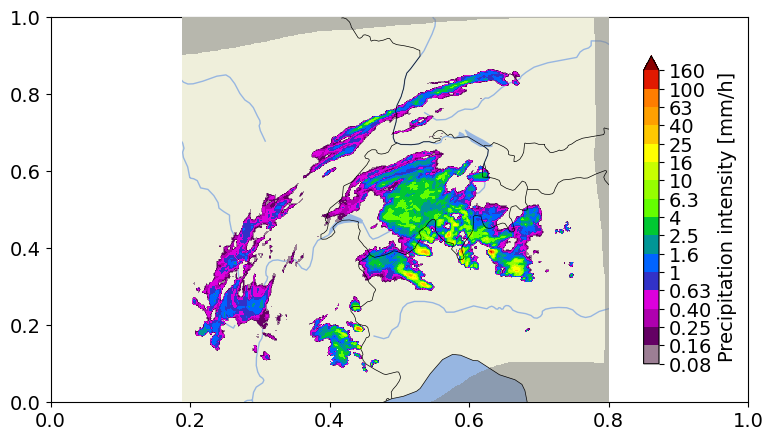

In [47]:
plt.figure(figsize=(9, 5), dpi=100)
plot_precip_field(precip_forecast[0], geodata=metadata, axis="off")
plt.show()


plt.figure(figsize=(9, 5), dpi=100)
plot_precip_field(precip_forecast[-1], geodata=metadata, axis="off")
plt.show()

## Evaluate the forecast quality

Many verification methods are already present in pysteps (see a complete list [here](https://pysteps.readthedocs.io/en/latest/pysteps_reference/verification.html)). We just have to import them.

Here, we will evaluate our forecast using the Fractions Skill Score (FSS).
This metric provides an intuitive assessment of the dependency of forecast skill on spatial scale and intensity. This makes the FSS an ideal skill score for high-resolution precipitation forecasts.

More precisely, the FSS is a neighborhood spatial verification method that directly compares the fractional coverage of events in windows surrounding the observations and forecasts.
The FSS varies from 0 (total mismatch) to 1 (perfect forecast).
For most situations, an FSS value of > 0.5 serves as a good indicator of a useful forecast ([Roberts and Lean, 2008](https://journals.ametsoc.org/doi/full/10.1175/2007MWR2123.1) and [Skok and Roberts, 2016](https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/qj.2849)).

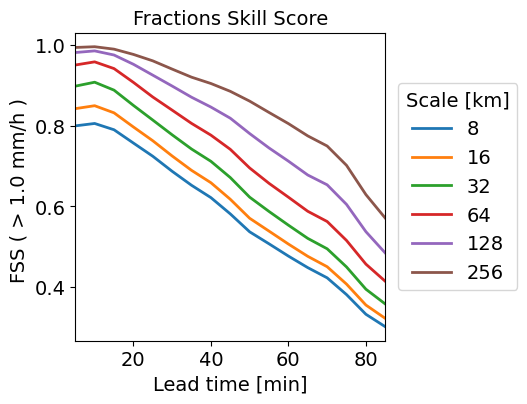

In [48]:
from pysteps import verification

fss = verification.get_method("FSS")

# Compute fractions skill score (FSS) for all lead times for different scales using a 1 mm/h detection threshold.
scales = [
    2,
    4,
    8,
    16,
    32,
    64,
]  # In grid points.

scales_in_km = np.array(scales) * 4

# Set the threshold
thr = 1.0  # in mm/h

score = []

# Calculate the FSS for every lead time and all predefined scales.
for i in range(n_leadtimes):
    score_ = []
    for scale in scales:
        score_.append(
            fss(precip_forecast[i, :, :], observed_precip[i, :, :], thr, scale)
        )
    score.append(score_)

# Now plot it
plt.figure()
x = np.arange(1, n_leadtimes + 1) * timestep
plt.plot(x, score, lw=2.0)
plt.xlabel("Lead time [min]")
plt.ylabel("FSS ( > 1.0 mm/h ) ")
plt.title("Fractions Skill Score")
plt.legend(
    scales_in_km,
    title="Scale [km]",
    loc="center left",
    bbox_to_anchor=(1.01, 0.5),
    bbox_transform=plt.gca().transAxes,
)
plt.autoscale(axis="x", tight=True)
plt.show()

As you can see, the FSS decreases with increasing lead time.
This is expected, as the forecasting quality slowly decreases when we forecast further ahead.
Upscaling the forecast, however, clearly leads to higher skill (up to longer ahead) compared to the forecast on the highest resolutions.

## Concluding remarks
Congratulations, you have successfully made your first nowcast using the pysteps library!
This was a simple extrapolation-based nowcast and a lot more advanced options are possible too, see [the pysteps examples gallery](https://pysteps.readthedocs.io/en/latest/auto_examples/index.html) for some nice examples.